### $\text{Data Driven Denoising of Accelerometer Signals}$

**Abstract:** This notebook contains 'Warmstarting' code for uploading directly the pretrained model weights implemented in our paper, and compare executions.

$$
\text{Enjoy  :-)}
$$

$\text{Customary imports}$

In [ ]:
#@title

# ===================================================== #
#             Import from Drive Environment             #
# ===================================================== #
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
import os, time, torch
import torch.nn as nn
from torch.autograd import Variable
from google.colab import drive

%matplotlib inline
np.random.seed(0)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(seed=42)

In [ ]:
# ===================================================== #
#                Set Working Directory                  #
# ===================================================== #

PATH_mount = '/content/gdrive'
drive.mount(PATH_mount)
PATH_process = PATH_mount + '/MyDrive/IMU-Denoising/Execution/Inference'
PATH_pretrained = PATH_process+'/pretrained'
os.chdir(PATH_process)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


$\text{INS-related functions}$

In [ ]:
#@title
    
def update_geo( lat, h ):
    """Update earth params"""
    Rm = ( Re*(1-E_2) ) / ( 1-E_2*np.sin(lat)**2 )**1.5  
    Rn = ( Re         ) / ( 1-E_2*np.sin(lat)**2 )**0.5
    g_n = np.array([0, 0, (-1)*9.780318*(Re/( Re+h ))**2 * (1+0.0052884*np.sin( lat )**2 - 0.0000059*np.sin( 2*lat )**2)])
    return Rn, Rm, g_n


Re = 6378137                        # m
ecc = 0.0818191908426215            # Earth eccentricity, e2 = 2*f-f^2
E_2 = ecc**2                        # squared eccentricity
w_ie = 7292115e-11                  # Earth's rotation rate
W_ie = [0, 0, w_ie]                 # Project  on INS
Rad2Deg = 180/np.pi                 # Degree   to Radians
Deg2Rad = 1/Rad2Deg                 # Radians  to Degree
DegHR_2_RadSEC = Deg2Rad/3600       # Deg/Hour to Rad/Sec
_, _, g_n = update_geo( 0, 0 )      # Local g-force
m_g = 0.001*np.abs(g_n[-1])         # milli-g

$\text{Configuration}$

In [ ]:
class CFG:
    # Physical params
    smp_rate = 100                       # [Hz]
    dt     = 1/smp_rate                  # [sec]
    window_size = 200                    # [steps in window]

    # Architecture params
    batch_size = 100
    Epochs     = 200
    lr_max     = 1e-3
    num_workers = 0

$\text{Upload ZIP data}$

Ensure that directory path is valid and approachable to code.

In [ ]:
#@title
def load_file( file_name ):
    return torch.load(PATH_process+'/data'+'/'+file_name)

X_train_GT, X_train_noisy, y_train = load_file('X_train_GT.pt'), load_file('X_train_noisy.pt'), load_file('y_train.pt')
X_valid_GT, X_valid_noisy, y_valid = load_file('X_valid_GT.pt'), load_file('X_valid_noisy.pt'), load_file('y_valid.pt')
X_test_GT,  X_test_noisy,  y_test  = load_file('X_test_GT.pt'), load_file('X_test_noisy.pt'), load_file('y_test.pt')

# Update CFG params
CFG.num_train, CFG.num_valid, CFG.num_test = X_train_GT.shape[0], X_valid_GT.shape[0], X_test_GT.shape[0]
CFG.window_size = X_train_GT.shape[1]
CFG.t_lin       = torch.arange(0, CFG.window_size/CFG.smp_rate, step=1/CFG.smp_rate )

$\text{Upload into Dataloaders}$

To improve modularity and automation, measurements are storaged in pre-loaded datasets such that usage during optimization become simpler and quicker.

In [ ]:
#@title

train_set, valid_set, test_set = [], [], []
# print('------------- Training ---------------')
for j in range( X_train_GT.shape[0] ):
    train_set.append( (X_train_noisy[j], X_train_GT[j], y_train[j]) )

# print('------------- Validation ---------------')
for j in range( X_valid_GT.shape[0] ):
    valid_set.append( (X_valid_noisy[j], X_valid_GT[j], y_valid[j]))
    test_set.append(  (X_test_noisy[j],  X_test_GT[j] , y_test[j]) )

# Use Data Loaders
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

class data_loader(Dataset):
    """ Input : Dataset
        Output: Transformed data """
    def __init__(self, data):
        self.data = []
        for (x_i, x_GT_i, y_i) in data:
            # VARIABLE: To accumulate gradients 
            x_Noise = Variable( torch.Tensor(x_i), requires_grad=True) # >> slows-down: .to(device)
            x_GT    = Variable( torch.Tensor(x_GT_i), requires_grad=True) # >> slows-down: .to(device)
            self.data.append((x_Noise, x_GT, y_i))
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return len(self.data)

train_dataset    = data_loader( train_set )
train_dataloader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=CFG.num_workers)

valid_dataset    = data_loader( valid_set )
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=CFG.num_workers)

test_dataset     = data_loader( test_set )
test_dataloader  = DataLoader(dataset=test_dataset, batch_size=CFG.batch_size, shuffle=False, drop_last=True, pin_memory=True, num_workers=CFG.num_workers)

### $\text{Visualizatons}$

The points below denote the roll and pitch labels ($\phi, \theta$), corresponding to each accelerometer sample from the test-set.

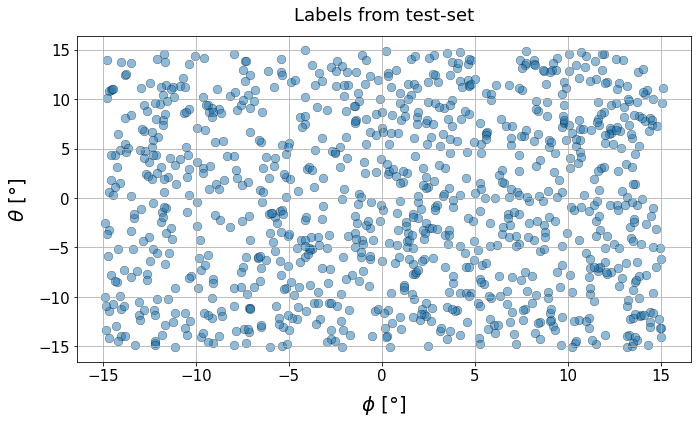

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(11, 6))
ax.set_title(r'Labels from test-set', fontsize=18, pad=15)
ax.scatter(y_test[:1000, 0]*Rad2Deg, y_test[:1000, 1]*Rad2Deg, label='GT', alpha=0.5, ec='k', lw=0.5, s=75)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$\phi \ [ \degree ]$', fontsize=20, labelpad=10)
ax.set_ylabel(r'$\theta \ [ \degree ]$', fontsize=20, labelpad=10)
ax.grid(True)

$\text{Random Example}$

* Hit the ( ▶ ) button below to compare between two random accelerometer readings

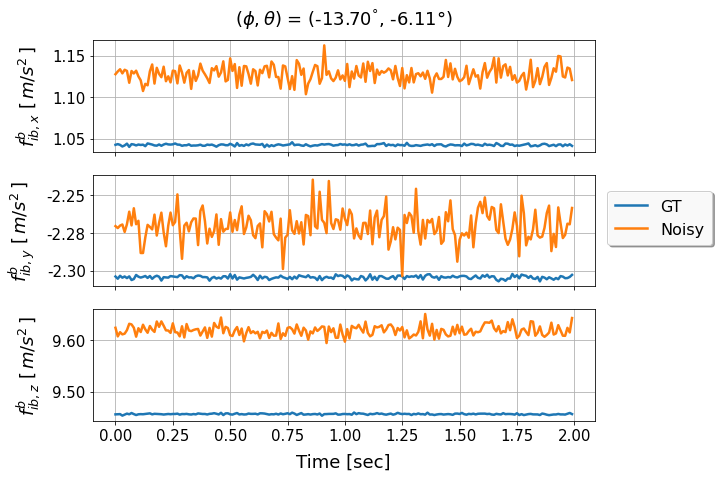

In [ ]:
#@title
n_i = random.sample(range(CFG.num_train), 1)[0]
a1, a2 = y_train[n_i,0].item()*Rad2Deg, y_train[n_i,1].item()*Rad2Deg
fig, ax = plt.subplots(3, figsize=(9, 7), sharex=True)
ax[0].set_title(r'$(\phi, \theta)$ = ({:.2f}$^\degree$, {:.2f}$\degree$)'.format(a1, a2), fontsize=18, pad=15)

L_w = 2.5
xx_gt, xx_ns = X_train_GT[n_i], X_train_noisy[n_i]
ax[0].plot(CFG.t_lin, xx_gt[:, 0], linewidth=L_w, label='GT')
ax[0].plot(CFG.t_lin, xx_ns[:, 0], linewidth=L_w, label='Noisy')
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_ylabel(r'$f_{ib,x}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10) # ['$\omega_{ib,x}^b$'], 
ax[0].grid(True)

ax[1].plot(CFG.t_lin, xx_gt[:, 1], linewidth=L_w, label='GT')
ax[1].plot(CFG.t_lin, xx_ns[:, 1], linewidth=L_w, label='Noisy')
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].set_ylabel(r'$f_{ib,y}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10) # ['$\omega_{ib,y}^b$']
ax[1].legend(loc='upper right', framealpha=0.95, fontsize=16, shadow=True, borderpad=0.5, bbox_to_anchor=(1.25, 0.925))
ax[1].grid(True)

ax[2].plot(CFG.t_lin, xx_gt[:, 2], linewidth=L_w, label='GT')
ax[2].plot(CFG.t_lin, xx_ns[:, 2], linewidth=L_w, label='Noisy')
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[2].set_ylabel(r'$ f_{ib,z}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10)
ax[2].set_xlabel(r'Time [sec]', fontsize=18, labelpad=10) # ['$\omega_{ib,z}^b$']
ax[2].grid(True)

from matplotlib.ticker import FormatStrFormatter
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

$\text{Stationary coarse alignment (levelling)}$

Should only be accepted when vehicle is not maneuvering, thus $|\textbf{f}_{ib}^b|=|\textbf{g}_b^n|$ :

$$
\phi_{nb} = \arctan_2 \big( -f_{ib,y}^b \, , \, -f_{ib,z}^b \big) \hspace{2cm}
\theta_{nb} = \arctan \big( \, \frac{-f_{ib,x}^b}{ \sqrt{f_{ib,y}^b{}^2 + f_{ib,z}^b{}^2} } \, \big) \\
$$ 

In [ ]:
#@title
def levelling( f_ib, g_sign=+1 ):
    ''' input : specific force measurements (negative-g (-9.8) ? flips sign !) <-- depends on coordinate system of inertial sensor
        output: pitch and roll angles
    '''
    phi   = torch.atan2( g_sign*f_ib[:,1], g_sign*f_ib[:,2] )
    theta = torch.atan(  -f_ib[:,0] / np.sqrt( f_ib[:,1]**2 + f_ib[:,2]**2 ) ).squeeze()  # bounded [-90, +90]
    return torch.vstack((phi, theta)).T

def angles_check( X_data_GT ):
    ''' input : accelerometer measurements
        output: computed pitch and roll angles
    '''
    f_x, f_y, f_z = X_data_GT[:,0], X_data_GT[:,1], X_data_GT[:,2]
    c_Euler = levelling( torch.tensor([f_x, f_y, f_z]).T ).mean(0)*Rad2Deg
    return c_Euler[0].item(), c_Euler[1].item()

import warnings
warnings.filterwarnings("ignore") # <-- ignore tensor scalar warnings

ang_1, ang_2 = angles_check( xx_gt.numpy() )
# ang_1, ang_2 = ang_1.item(), ang_2
print('------ Computed attitude angles ------')
print('phi: {:.3f} [deg] \ntheta: {:.3f} [deg]'.format( ang_1, ang_2 ))

------ Computed attitude angles ------
phi: -13.695 [deg] 
theta: -6.112 [deg]


### $\text{Inference Models}$

As presented in the paper, the following DL models are loaded and used for inference over test-set:

1. Unidirectional bi-layer LSTM
2. Bi-directional one-layer RNN
3. Bi-directional one-layer GRU

$\text{Models Hyperparameters}$

These parameters are dictated by the pretrained models, see: '`models_architecture.py`' and '`models_params.py`'

* Notice that `models_params.py` must follow same parameters during training ...

In [ ]:
#@title

dim_input = 3                       # Input  dimension
dim_out   = 3                       # Output dimension
dropout_val = 0.15

bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1

$\text{Load pretrained models}$

In [ ]:
#@title

execfile('models_architecture.py'); execfile('models_params.py');

if device.type=='cpu':
    map_location = torch.device('cpu')
else:
    map_location=[]

model_lstm = LSTM(*LSTM_params()).to(device)
model_lstm.load_state_dict( torch.load( PATH_pretrained+'/LSTM-pretrained.pt', map_location=map_location ), strict=False )

model_rnn = RNN(*RNN_params()).to(device)
model_rnn.load_state_dict( torch.load( PATH_pretrained+'/RNN-pretrained.pt', map_location=map_location ), strict=False )

model_gru = GRU(*GRU_params()).to(device)
model_gru.load_state_dict( torch.load( PATH_pretrained+'/GRU-pretrained.pt', map_location=map_location ), strict=False )

<All keys matched successfully>

$\text{Sanity check - batch upload (optional)}$

In [ ]:
#@title

# x_i, _, _ = next(iter(valid_dataloader))
# x_inp = x_i.to(device)
# x_pred = model_rnn( x_inp ).to(device)

### $\text{Inference}$

1. Perform inference (GPU-free) using pre-trained models

2. Compare performances with SP-based

In [ ]:
#@title

seed_everything(seed=42)
loss_func = nn.MSELoss(reduction='mean').to(device)

y_ref = X_test_GT.to(device)
X_LSTM, X_RNN, X_GRU = torch.zeros( X_test_noisy.shape ), torch.zeros( X_test_noisy.shape ), torch.zeros( X_test_noisy.shape )

with torch.no_grad():
    for (ii, (x_i, x_GT_i, _)) in enumerate(test_dataloader):
        X_LSTM[ii*CFG.batch_size:(ii+1)*CFG.batch_size] = model_lstm(x_i.to(device) )
        X_RNN[ii*CFG.batch_size:(ii+1)*CFG.batch_size]  = model_rnn( x_i.to(device) )
        X_GRU[ii*CFG.batch_size:(ii+1)*CFG.batch_size]  = model_gru( x_i.to(device) )

### $\text{Signal processing (SP-based) optimization}$

* Since a large number of error sources (stochastic & deterministic) are introduced in the experiment, no prior knowledge can be used to guarantee an optimal tunning, or compensating the bias terms. To that end, an heuristic search is conducted over the governing factors. 

* For example, given $k$ optimization arguments, running time is upper bounded by a polynomial complexity of  $\ \mathcal{O}(n^k)$.

$\text{Moving Average}$

suppresses unstable signal noises by averaging measurements inside a rolling window:

\begin{align}
\hat{\boldsymbol{x}}_{\textbf{MA},i} = \frac{1}{T} \sum_{t = 0}^{T-1} \boldsymbol{x}_{i+t-T} \quad \forall \ i \geq T
% MA_k = \frac{1}{k} \sum_{t=n-k+1}^{n} p_t
\end{align}


where $\boldsymbol{x}_{i}$ is a noisy sample and $T$ is the window size.

In [ ]:
#@title
X_MA = X_test_noisy.mean(1).to(device)
print('MA  Loss: {:.5f}'.format( loss_func(X_MA, y_ref.mean(1).to(device) ).item() ))

MA  Loss: 0.01205


$\text{Golay-Savitsky}$

allows denoising by deriving observations directly from time domain, thus avoiding spectral decomposition. By fitting successive sets of adjacent points with a low-degree polynomial, followed by least-squares regression, local noise is smoothed out. Noisy signal $\boldsymbol{x}_{i}$ is replaced with a set of $m$ convolution coefficients $C_t$,

\begin{align}
\hat{\boldsymbol{x}}_{\textbf{SG},i} = \sum_{t=-t_s}^{t_s} C_t  \boldsymbol{x}_{i+t} \ , \quad \tfrac{m+1}{2} \leq t \leq t_f - \tfrac{m-1}{2}
\end{align}

where $t_f$ is the duration of data point $x_t$ and $t_s = \frac{m-1}{2}$ denotes the window margins.

In [ ]:
#@title
from scipy.signal import savgol_filter
def SavGol(X, window_length, polyorder):
    return torch.tensor( savgol_filter(X, window_length, polyorder, deriv=0) )


# # -------- OPTIONAL: Optimization Loop (~10 mins) --------- #
# 
#   UNCOMMENT for heauristic optimization. 
#
# Dict = {'Window_size':[], 'Poly_order':[], 'res':[]}; Dict['res'].append( 100 )
# dim_i = 2
# for i in range(11, CFG.window_size, 2):
#     for j in range(1, 11):
#         X_SG = SavGol(X_test_noisy[:,:,dim_i], i, j)
#         res = loss_func(X_SG[:CFG.batch_size].to(device), y_ref[:CFG.batch_size,:,dim_i] ).item()
#         if res < Dict['res'][-1]:
#             Dict['Window_size'].append(i); Dict['Poly_order'].append(j); Dict['res'].append(res)
# ws_opt, po_opt = Dict['Window_size'][-1], Dict['Poly_order'][-1]
# # --------------------------------------------------------- #

ws_opt, po_opt = 17, 13           # optimization result
X_SG_0 = SavGol(X_test_noisy[:,:,0], ws_opt, po_opt).to(device).unsqueeze(2)
X_SG_1 = SavGol(X_test_noisy[:,:,1], ws_opt, po_opt).to(device).unsqueeze(2)
X_SG_2 = SavGol(X_test_noisy[:,:,2], ws_opt, po_opt).to(device).unsqueeze(2)
X_SG = torch.cat([X_SG_0, X_SG_1, X_SG_2], dim=2)

print('GS Loss (ws={}, poly_order={}): {:.5f}'.format( ws_opt, po_opt, loss_func(X_SG, y_ref ).item() ))

GS Loss (ws=17, poly_order=13): 0.01211


$\text{Discrete Wavelet Transformation}$

the most common denoising technique, where input signal $\boldsymbol{x}_i$ is represented in both time and frequency domains, by decomposing it into a set of basis functions. Here, a Daubechies (db4) mother wavelet function ($\psi$) is used with different scaling ($a=2$) and shifting ($b$) parameters, providing a progressively finer outputs, given by coefficients matrix $\Psi$

\begin{align}
\Psi_i[b,a^j] &= \sum_{t=0}^{N-1} \boldsymbol{x}_i[t] \frac{1}{\sqrt{a^j}} \psi_{j} \left( \frac{t-b}{a^j} \right)
% \Psi_{b,a^j} &= \sum_{t=0}^{N-1} x[t] \psi_{j}[t-b]  \\
% \psi_{j}[b]  &= \frac{1}{\sqrt{a^j}} \psi \big( \frac{b}{a^j} \big)
\end{align}

Since small valued coefficients are dominated by noise, hard thresholding $\text{T}_{\text{Hard}}$ is used to remove them, thus preserving only meaningful information. Then, an inverse transform is applied on the thresholded wavelet coefficients, to reconstruct the denoised matrix back to time domain signal as given by

\begin{align}
\hat{\boldsymbol{x}}_{\text{DWT},i} = \Big( \text{T}_{\text{Hard}} (\Psi_{i} ) \Big)^{-1} 
\end{align}

In [ ]:
#@title
import pywt
from statsmodels.robust import mad

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1, mode='symmetric'): # 'Daubechies 4 - mother wavelet'
    coeff = pywt.wavedec(x, wavelet, mode)                       # wavedec := Multilevel 1D DWT decomposition
    sigma = (1/0.6745) * maddest(coeff[-level])                  # Median Absolute Deviation. Proof of constant @ literature
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    # Hard thresholding is followed by inverse spectral transform
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return torch.tensor( pywt.waverec(coeff, wavelet, mode) )

X_DWT = denoise_signal(X_test_noisy).to(device)
X_DWT_0 = denoise_signal(X_test_noisy[:,:,0]).to(device).unsqueeze(2)
X_DWT_1 = denoise_signal(X_test_noisy[:,:,1]).to(device).unsqueeze(2)
X_DWT_2 = denoise_signal(X_test_noisy[:,:,2]).to(device).unsqueeze(2)
X_DWT = torch.cat([X_DWT_0, X_DWT_1, X_DWT_2], dim=2)

print('DWT Loss : {:.5f}'.format( loss_func(X_DWT, y_ref ).item() )) # ws_opt, po_opt,  (ws={}, poly_order={})

DWT Loss : 0.01205


$\text{KNN Regressor - Ensemble}$

Our last proposed model does not assume priors on the underlying distribution, but is only determined by the number of $k$ nearest neighbors. Let the dataset be a set of $n$ pairs of noisy and GT samples:

\begin{align}
\mathcal{D} = \{( \boldsymbol{x}_i, \boldsymbol{x}_{_{GT},i} ) \}_{i=1}^n 
\end{align}

where denoised outputs are determined by the mean GT value of $k$ closest (noisy) samples to the new data point

\begin{align}
\hat{\boldsymbol{x}}(k) = \frac{1}{k} \sum_{ \boldsymbol{x}_i \in \boldsymbol{N}(k) }  \boldsymbol{x}_{_{GT},i}
% \Big( \tilde{\textbf{x}}_i - \textbf{x}_{_{GT},i} \Big) \ \in \ \mathbb{R}^m
\end{align}

Given r-dimensional data points $\boldsymbol{x}_1$ and $\boldsymbol{x}_2$, neighborhood $\boldsymbol{N}$ will be consisted of $k$ closest neighbors, as proximity is calculated using an Euclidean distance function

\begin{align}
% d( \boldsymbol{p}, \boldsymbol{q} ) = \sqrt{ \sum_{ j=1 }^{r}  ( p_{j} - q_{j} )^2 }
d( \boldsymbol{x}_1, \boldsymbol{x}_2 ) = \sqrt{ \sum_{ j=1 }^{r}  ( x_{1,j} - x_{2,j} )^2 }
\end{align}

In [ ]:
#@title
from sklearn.neighbors import KNeighborsRegressor

def Reg_KNN(a_i, X_train_noisy, X_train_GT, X_test_noisy):
    Reg = KNeighborsRegressor(n_neighbors=a_i, weights='uniform')
    # NOTICE: .fit := storing the entire dataset, NOT for learning process !!!
    Reg.fit(X_train_noisy, X_train_GT) 
    return torch.tensor( Reg.predict(X_test_noisy) )

# -------- OPTIONAL: Optimization Loop (~20 mins) -------- #
#
# Find heauristically optimal k nearest neighbors.
#
# Dict = {'alpha_i':[], 'res':[]}; Dict['res'].append( 100 )
# for a_i in range(1, 50):
#     X_KNN = Reg_KNN(a_i, X_train_noisy, X_train_GT, X_test_noisy)
#     res = loss_func(X_KNN.to(device), y_ref ).item()
#     if res < Dict['res'][-1]:
#         Dict['alpha_i'].append(a_i); Dict['res'].append(res)
# -------------------------------------------------------- #

KNN_opt = int(np.sqrt(CFG.num_test))              # Optimal k was obtained by heuristics ~ SQRT(sample_size)
X_KNN_0 = Reg_KNN(KNN_opt, X_train_noisy[:,:,0], X_train_GT[:,:,0], X_test_noisy[:,:,0]).to(device).unsqueeze(2)
X_KNN_1 = Reg_KNN(KNN_opt, X_train_noisy[:,:,1], X_train_GT[:,:,1], X_test_noisy[:,:,1]).to(device).unsqueeze(2)
X_KNN_2 = Reg_KNN(KNN_opt, X_train_noisy[:,:,2], X_train_GT[:,:,2], X_test_noisy[:,:,2]).to(device).unsqueeze(2)
X_KNN = torch.cat([X_KNN_0, X_KNN_1, X_KNN_2], dim=2)
print('KNN Loss ({} neighbors): {:.5f}'.format(KNN_opt, loss_func(X_KNN, y_ref ).item() ))

KNN Loss (134 neighbors): 0.00025


$\text{Evaluation Metrics}$

In [ ]:
MSE  = nn.MSELoss() #.to(device)
RMS  = lambda x:(torch.sqrt(torch.mean(x**2)))
RMSE = lambda y_pred, y_GT: (torch.sqrt( MSE(y_pred, y_GT) ).item())                                    # Root Mean Square
MAE  = lambda y_pred, y_GT: (torch.mean( torch.abs(y_pred - y_GT) )).item()                             # Mean Absolute Error
RAE  = lambda y_pred, y_GT: (torch.norm( y_GT-y_pred) / torch.norm(y_GT)*100).item()                    # Relative Absolute Error [%]
PSNR = lambda y_pred, y_GT: (20*torch.log10( torch.max(torch.abs(y_GT)) / RMSE(y_pred,y_GT))).item()    # Ratio Peak signal-to-noise ratio-Amplitude [dB]
SNR  = lambda Amp_1, Amp_2: (20*torch.log10( RMS( Amp_1 ) / RMS( Amp_2 ) )).item()                      # Ratio between signal-to-NOISE (only) RMS-Amplitude [dB] <-- useless when noise cannot be isolated

### $\text{Inference}$

* Denoised products are compared with GT (blue)

* Executions are drawn randomly from the test-set

* Hit the ( ▶ ) button below to draw random infernce !

In [ ]:
#@title
lables_models = ['$\hat{y}_{GT}$', '$\hat{y}_{LSTM}$', '$\hat{y}_{RNN}$', '$\hat{y}_{GRU}$', '$\hat{y}_{SG}$', '$\hat{y}_{KNN}$', '$\hat{y}_{MA}$', '$\hat{y}_{DWT}$', 'Noise']
n_i = random.sample(range(y_ref.shape[0]), 1)[0]
y_GT_single  = y_ref[n_i].cpu()
y_GRU = X_GRU[n_i].cpu()
y_LSTM= X_LSTM[n_i].cpu()
y_RNN = X_RNN[n_i].cpu()
y_SG  = X_SG[n_i].cpu()
y_KNN = X_KNN[n_i].cpu()
y_MA  = X_MA[n_i].cpu().repeat(CFG.window_size, 1)
y_DWT = X_DWT[n_i].cpu()
y_nsy = X_test_noisy[n_i].cpu()

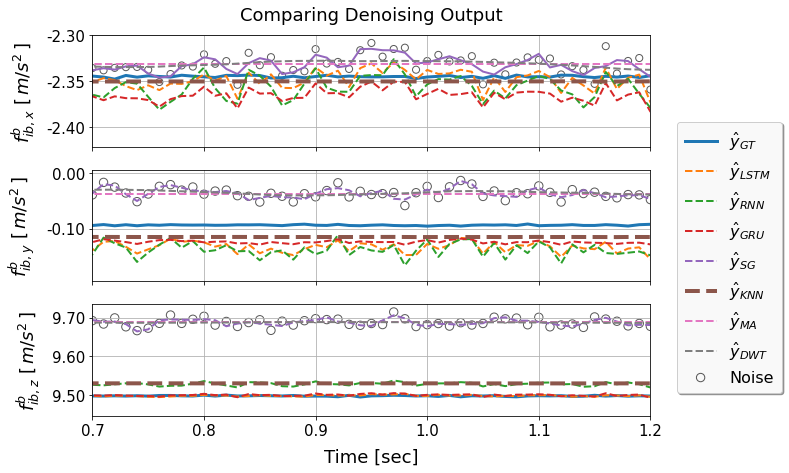

In [ ]:
#@title
n_i = random.sample(range(len(y_test)), 1)[0]
a1, a2 = y_test[n_i,0].item()*Rad2Deg, y_test[n_i,1].item()*Rad2Deg

L_w = 2.

fig, ax = plt.subplots(3, figsize=(10, 7), sharex=True)
# ax[0].set_title(r'Reconstruction @ [$\phi, \theta, \psi$]=[{:.2f}, {:.2f}, {:.2f}]'.format(a1, a2, a3), fontsize=18, pad=15)
ax[0].set_title(r'Comparing Denoising Output', fontsize=18, pad=15)
ax[0].plot(CFG.t_lin, y_GT_single[:,0], ls='-', linewidth=3.)
ax[0].plot(CFG.t_lin, y_LSTM[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, y_RNN[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, y_GRU[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, y_SG[:,0], linewidth=L_w)
ax[0].plot(CFG.t_lin, y_KNN[:,0], ls='--', linewidth=L_w*2.)
ax[0].plot(CFG.t_lin, y_MA[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, y_DWT[:,0], ls='--', linewidth=L_w)
ax[0].scatter(CFG.t_lin, y_nsy[:,0], s=50, edgecolors='k', facecolors='none', alpha=0.65)
ax[0].set_ylabel(r'$f_{ib,x}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10) # ['$\omega_{ib,x}^b$'], 
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid(True)

ax[1].plot(CFG.t_lin, y_GT_single[:,1], ls='-', linewidth=3.)
ax[1].plot(CFG.t_lin, y_LSTM[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, y_RNN[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, y_GRU[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, y_SG[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, y_KNN[:,1], ls='--', linewidth=L_w*2.)
ax[1].plot(CFG.t_lin, y_MA[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, y_DWT[:,1], ls='--', linewidth=L_w)
ax[1].scatter(CFG.t_lin, y_nsy[:,1], s=70, edgecolors='k', facecolors='none', alpha=0.65)
ax[1].set_ylabel(r'$f_{ib,y}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10) # ['$\omega_{ib,x}^b$'], 
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].grid(True)
ax[1].legend(lables_models, loc='upper right', framealpha=0.95, fontsize=16, shadow=True, borderpad=0.5, bbox_to_anchor=(1.25, 1.5))

ax[2].plot(CFG.t_lin, y_GT_single[:,2], ls='-', linewidth=3.)
ax[2].plot(CFG.t_lin, y_LSTM[:,2], ls='--', linewidth=L_w)
ax[2].plot(CFG.t_lin, y_RNN[:,2], ls='--', linewidth=L_w)
ax[2].plot(CFG.t_lin, y_GRU[:,2], ls='--', linewidth=L_w)
ax[2].plot(CFG.t_lin, y_SG[:,2], ls='--', linewidth=L_w)
ax[2].plot(CFG.t_lin, y_KNN[:,2], ls='--', linewidth=L_w*2.)
ax[2].plot(CFG.t_lin, y_MA[:,2], ls='--', linewidth=L_w)
ax[2].plot(CFG.t_lin, y_DWT[:,2], ls='--', linewidth=L_w)
ax[2].scatter(CFG.t_lin, y_nsy[:,2], s=70, edgecolors='k', facecolors='none', alpha=0.65)
ax[2].set_ylabel(r'$f_{ib,z}^b \ [ \, m/s^2 \, ]$', fontsize=18, labelpad=10) # ['$\omega_{ib,x}^b$'], 
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[2].set_xlabel(r'Time [sec]', fontsize=18, labelpad=10) # ['$\omega_{ib,z}^b$']
ax[2].set_xlim([0.7, 1.2])
ax[2].grid(True)

from matplotlib.ticker import FormatStrFormatter
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

$\text{Roll & pitch angles}$

Use the denoised outputs from above to perform stationary coarse alignment. 

Namely, calculate their corresponding roll & pitch angles:

In [ ]:
#@title
l_GT  = levelling( y_GT_single )*Rad2Deg
l_LSTM = levelling(y_LSTM)*Rad2Deg
l_RNN = levelling( y_RNN )*Rad2Deg
l_GRU = levelling( y_GRU )*Rad2Deg
l_KNN = levelling( y_KNN )*Rad2Deg
l_SG  = levelling( y_SG  )*Rad2Deg
l_nsy = levelling( y_nsy )*Rad2Deg
l_DWT = levelling( y_DWT )*Rad2Deg
l_MA  = levelling( y_MA )*Rad2Deg

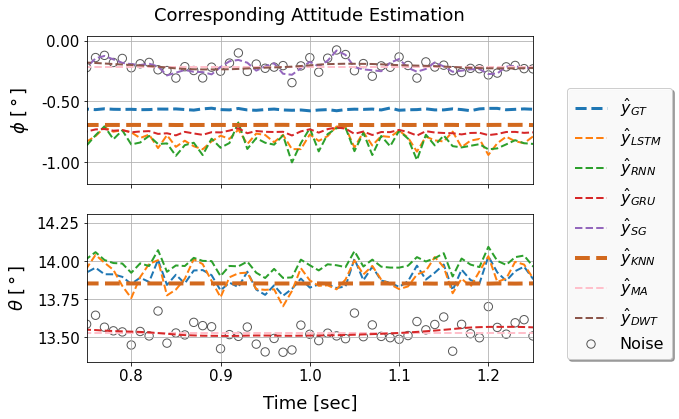

In [ ]:
#@title
L_w = 2.
fig, ax = plt.subplots(2, figsize=(8, 6), sharex=True)
ax[0].set_title(r'Corresponding Attitude Estimation', fontsize=18, pad=15) #: ($\phi, \theta$) = ({:.3f}, {:.3f})'.format( ang_1, ang_2 ), fontsize=18, pad=15)
ax[0].plot(CFG.t_lin, l_GT[:,0], ls='--', linewidth=3.)
ax[0].plot(CFG.t_lin, l_LSTM[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, l_RNN[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, l_GRU[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, l_SG[:,0], ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, l_KNN[:,0], c='chocolate', ls='--', linewidth=L_w*2.)
ax[0].plot(CFG.t_lin, l_MA[:,0], c='pink', ls='--', linewidth=L_w)
ax[0].plot(CFG.t_lin, l_DWT[:,0], ls='--', linewidth=L_w)
ax[0].scatter(CFG.t_lin, l_nsy[:,0], s=70, edgecolors='k', facecolors='none', alpha=0.65)

ax[0].legend(lables_models, loc='upper right', framealpha=0.95, fontsize=16, shadow=True, borderpad=0.5, bbox_to_anchor=(1.33, 0.7))
ax[0].set_ylabel(r'$\phi \ [ \, \degree \, ]$', fontsize=18, labelpad=10)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid(True)

ax[1].plot(CFG.t_lin, l_LSTM[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, l_RNN[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, l_GRU[:,1], ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, l_KNN[:,1], c='chocolate', ls='--', linewidth=L_w*2.)
ax[1].plot(CFG.t_lin, l_MA[:,1], c='pink', ls='--', linewidth=L_w)
ax[1].plot(CFG.t_lin, l_DWT[:,1], ls='--', linewidth=L_w)
ax[1].scatter(CFG.t_lin, l_nsy[:,1], s=70, edgecolors='k', facecolors='none', alpha=0.65)

ax[1].set_ylabel(r'$\theta \ [ \, \degree \, ]$', fontsize=18, labelpad=10)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].grid(True)
ax[1].set_xlabel(r'Time [sec]', fontsize=18, labelpad=10) # ['$\omega_{ib,z}^b$']
ax[1].set_xlim([0.75, 1.25])

from matplotlib.ticker import FormatStrFormatter
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#### $\text{Benchmarking}$

Use several metrics to examine the reconstruction error over the entire test set:

In [ ]:
#@title

def evaluate_model( y_Ref, y_hat, MA=False ):
    ''' Input : GT & prediction vectors
        Output: scalar evaluation of performance
    '''
    if MA:
        y_Ref = y_ref.mean(1)
    return RMSE(y_hat,  y_Ref), MAE(y_hat,  y_Ref), PSNR(y_hat, y_Ref), RAE(y_hat, y_Ref)

Rows = ['Mean', 'SG', 'DWT', 'LSTM', 'RNN', 'GRU', 'KNN', 'Noisy'];  num_models  = len(Rows);
Cols = ['RMSE [m_s2]', 'MAE [m_s2]', 'PSNR [dB]', 'RAE [%]'];                      num_metrics = len(Cols);
X_comparison = [X_MA, X_SG, X_DWT, X_LSTM.to(device), X_RNN.to(device), X_GRU.to(device), X_KNN, X_test_noisy.to(device)]
df_metric = pd.DataFrame(data=np.zeros((num_models, num_metrics)), index=Rows, columns=Cols)

for i in range(num_models):
    df_metric.iloc[i] = evaluate_model( y_ref, X_comparison[i], Rows[i]=='Mean')

df_metric = df_metric.sort_values( by=['RMSE [m_s2]'] )
print(df_metric)

       RMSE [m_s2]  MAE [m_s2]  PSNR [dB]   RAE [%]
KNN       0.015705    0.012354  55.905830  0.277958
LSTM      0.016271    0.012756  55.598366  0.288032
GRU       0.019015    0.014535  54.244713  0.336562
RNN       0.022850    0.018447  52.648911  0.404648
Mean      0.109756    0.098231  39.015926  1.941807
DWT       0.109789    0.098234  39.015671  1.947536
SG        0.110033    0.098263  38.996372  1.951979
Noisy     0.110213    0.098288  38.982147  1.955184


### $\text{End-game: results analysis}$

Evaluate the overall contribution of the kNN model to the denoising task in two optimization aspects:

* Error minimization 
* PSNR  maximization.

In [ ]:
#@title
l_Euler_GT  = torch.zeros((X_test_GT.shape[0], 2))
l_KNN       = torch.zeros((X_test_GT.shape[0], 2))
l_nsy       = torch.zeros((X_test_GT.shape[0], 2))

for i in range( X_test_GT.shape[0] ):
    l_Euler_GT[i] = levelling( X_test_GT[i].cpu() ).mean(0)[:2]*Rad2Deg
    l_KNN[i]      = levelling( X_KNN[i].cpu() ).mean(0)*Rad2Deg
    l_nsy[i]      = levelling( X_test_noisy[i].cpu() ).mean(0)[:2]*Rad2Deg

def evaluate_model( y_Ref, y_hat):
    ''' Input : GT & prediction vectors
        Output: scalar evaluation of performance
    '''
    return RMSE(y_hat,  y_Ref), MAE(y_hat,  y_Ref), PSNR(y_hat, y_Ref), RAE(y_hat, y_Ref)

In [ ]:
#@title
Rows = ['phi-Noisy', 'phi-KNN','theta-Noisy', 'theta-KNN']; num_models  = len(Rows);
Cols = ['RMSE [deg]', 'MAE [deg]', 'PSNR [dB]', 'RAE [%]']; num_metrics = len(Cols);
X_comparison = [l_nsy[:,0], l_KNN[:,0], l_nsy[:,1], l_KNN[:,1]]
df_metric = pd.DataFrame(data=np.zeros((num_models, num_metrics)), index=Rows, columns=Cols)

l_ref = l_Euler_GT[:,0]
for i in range(len(X_comparison)):
    if i > 1:
        l_ref = l_Euler_GT[:,1]
    df_metric.iloc[i] = evaluate_model( l_ref, X_comparison[i])

df_metric = df_metric.sort_values( by=['RMSE [deg]'] )
print(df_metric)

             RMSE [deg]  MAE [deg]  PSNR [dB]   RAE [%]
theta-KNN      0.078308   0.062589  45.735428  0.898130
phi-KNN        0.080342   0.064364  45.522675  0.917967
theta-Noisy    0.352088   0.343603  32.678535  4.038159
phi-Noisy      0.470127   0.463465  30.177210  5.371552


$\text{Angular error reduction}$

In [ ]:
ratio_phi   = df_metric.loc['phi-KNN', 'RAE [%]'] / df_metric.loc['phi-Noisy', 'RAE [%]']
print('RAE : kNN-phi / Noisy-phi: {:.3f} [%]'.format( ratio_phi*100 ))

RAE : kNN-phi / Noisy-phi: 17.089 [%]


In [ ]:
ratio_theta = df_metric.loc['theta-KNN', 'RAE [%]'] / df_metric.loc['theta-Noisy', 'RAE [%]']
print('RAE : kNN-theta / Noisy-theta: {:.3f} [%]'.format( ratio_theta*100 ))

RAE : kNN-theta / Noisy-theta: 22.241 [%]


$$
- \ fin \ -
$$